**Name:** \_\_\_\_\_

**EID:** \_\_\_\_\_

# CS4487 - Tutorial 2: Text Document Classification with Naive Bayes

In this tutorial you will classify text documents using Naive Bayes classifers.  We will be working with the dataset called "20 Newsgroups", which is a collection of 20,000 newsgroup posts organized into 20 categories.

## 1. Loading the 20 Newsgroups Dataset
The dataset is called “20 Newsgroups”. Here is the official description, quoted from the [website](http://qwone.com/~jason/20Newsgroups/)
>The 20 Newsgroups data set is a collection of approximately 20,000 newsgroup documents, partitioned (nearly) evenly across 20 different newsgroups. To the best of our knowledge, it was originally collected by Ken Lang, probably for his paper “Newsweeder: Learning to filter netnews,” though he does not explicitly mention this collection. The 20 newsgroups collection has become a popular data set for experiments in text applications of machine learning techniques, such as text classification and text clustering.

In [1]:
#First we need to initialize Python.  Run the below cell.
%matplotlib inline
import IPython.core.display         
# setup output image format (Chrome works best)
IPython.core.display.set_matplotlib_formats("svg")
import matplotlib.pyplot as plt
import matplotlib
from numpy import *
from sklearn import *
from scipy import stats
random.seed(100)

- Put the file "20news-bydate_py3.pkz' into the same directory as this ipynb file. **Do not unzip the file**.

- Extract 4 classes ('alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space') from the dataset. 

In [2]:
# strip away headers/footers/quotes from the text
removeset = ('headers', 'footers', 'quotes')

# only use 4 categories
cats      = ['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']

# load the training and testing sets
newsgroups_train = datasets.fetch_20newsgroups(subset='train',
                           remove=removeset, categories=cats, data_home='./')
newsgroups_test  = datasets.fetch_20newsgroups(subset='test', 
                           remove=removeset, categories=cats, data_home='./')

- Check if we got all the data.  The training set should have 2034 documents, and the test set should have 1353 documents.

In [3]:
print("training set size:", len(newsgroups_train.data))
print("testing set size: ",  len(newsgroups_test.data))
print(newsgroups_train.target_names)

training set size: 2034
testing set size:  1353
['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc']


- Count the number examples in each class.  `newsgroups_train.target` is an array of class values (0 through 3), and `newsgroups_train.target[i]` is the class of the i-th document.

In [4]:
print("class counts")
for i in [0, 1, 2, 3]:
    print("{:20s}: {}".format(newsgroups_train.target_names[i], sum(newsgroups_train.target == i)))

class counts
alt.atheism         : 480
comp.graphics       : 584
sci.space           : 593
talk.religion.misc  : 377


- Show the documents.  `newsgroups_train.data` is a list of strings, and `newsgroups_train.data[i]` is the i-th document.

In [5]:
for i in [0, 1, 2 ,3]:
    print("--- document {} (class={}) ---".format(
        i, newsgroups_train.target_names[newsgroups_train.target[i]]))
    print(newsgroups_train.data[i])

--- document 0 (class=comp.graphics) ---
Hi,

I've noticed that if you only save a model (with all your mapping planes
positioned carefully) to a .3DS file that when you reload it after restarting
3DS, they are given a default position and orientation.  But if you save
to a .PRJ file their positions/orientation are preserved.  Does anyone
know why this information is not stored in the .3DS file?  Nothing is
explicitly said in the manual about saving texture rules in the .PRJ file. 
I'd like to be able to read the texture rule information, does anyone have 
the format for the .PRJ file?

Is the .CEL file format available from somewhere?

Rych
--- document 1 (class=talk.religion.misc) ---


Seems to be, barring evidence to the contrary, that Koresh was simply
another deranged fanatic who thought it neccessary to take a whole bunch of
folks with him, children and all, to satisfy his delusional mania. Jim
Jones, circa 1993.


Nope - fruitcakes like Koresh have been demonstrating such evil 

**Tip:** while you do the tutorial, it is okay to make additional code cells in the file.  This will allow you to avoid re-running code (like training a classifier, then testing a classifier).

## 2. Extracting Features from Text Files
In order to perform machine learning on text documents, we first need to turn the text content into numerical feature vectors.

Next, we will introduce two basic text representation methods: One-hot encoding, Bag of words, and TF-IDF. More feature vector extraction functions, please refer to https://scikit-learn.org/stable/modules/classes.html#module-sklearn.feature_extraction

### one-hot encoding
- Each word is coded with an index, which is represented by one-hot.

> John likes to watch movies. Mary likes too.

> John also likes to watch football games.

If we need to represent the words in the above two sentences, you can encode the words as following:

> {"John": 1, "likes": 2, "to": 3, "watch": 4, "movies": 5, "also":6, "football": 7, "games": 8, "Mary": 9, "too": 10}

We can encode each word using one-hot method

>John: [1, 0, 0, 0, 0, 0, 0, 0, 0, 0]

>likes: [0, 1, 0, 0, 0, 0, 0, 0, 0, 0]

>...

#### However, this text representation method is impractical when the scale of corpus becomes large.

### Bag of Words
- The index value of a word in the vocabulary is linked to its frequency in the whole training corpus.

> John likes to watch movies. Mary likes too.  -->> [1, 2, 1, 1, 1, 0, 0, 0, 1, 1]

> John also likes to watch football games.     -->> [1, 1, 1, 1, 0, 1, 1, 1, 0, 0]

The **sklearn.feature_extraction.text.CountVectorizer** implement the `Bag of Words` method that converts a collection of text documents to a matrix of token counts. This implementation produces a sparse representation of the counts using **scipy.sparse.coo_matrix** to save memory by only storing the non-zero parts of the feature vectors in memory.

In [6]:
from sklearn.feature_extraction.text import CountVectorizer
 
corpus = ['This is the first document.',
	'This document is the second document.',
	'And this is the third one.',
	'Is this the first document?']
 
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(corpus)
 
print(vectorizer.get_feature_names())
print(X.toarray())


['and', 'document', 'first', 'is', 'one', 'second', 'the', 'third', 'this']
[[0 1 1 1 0 0 1 0 1]
 [0 2 0 1 0 1 1 0 1]
 [1 0 0 1 1 0 1 1 1]
 [0 1 1 1 0 0 1 0 1]]


### Term Frequency - Inverse Document Frequency (TF-IDF)

In the word bag model, we can get the vector representation of this text.However, in the face of the diversity of text, each word has different weight to the content of text in practical application, so we introduce tf-idf model.

##### TF (Term Frequency)

In the case of the term frequency $tf(t, d)$, the simplest choice is to use the raw count of a term in a document, i.e., the number of times that term $t$ occurs in document $d$. If we denote the raw count by $f_{t, d}$, then the simplest tf scheme is $tf(t,d) = f_{t, d}$. 

$tf_{t, d} = n_{t, d}/\sum_kn_{t, d}$

The numerator in the above formula is the number of occurrences of the word in the document $d$, and the denominator is the sum of the occurrences of all words in the document $d$.

##### IDF (Inverse Document Frequency) 

The inverse document frequency is a measure of how much information the word provides, i.e., if it's common or rare across all documents. It is the logarithmically scaled inverse fraction of the documents that contain the word (obtained by dividing the total number of documents by the number of documents containing the term, and then taking the logarithm of that quotient): 

$idf(t ,D) = log\frac{N}{|\{ d\in D:t \in d \}|}$

with 
- $N$: total number of documents in the corpus $N=|D|$
- $|\{ d\in D:t \in d \}|$: number of documents where the term $t$ appears. If the term is not in the corpus, this will lead to a division-by-zero. It is therefore common to adjust the denominator to  $1+|\{ d\in D:t \in d \}|$

Then tf-idf is calculated as: 
$tfidf(t, d, D) = tf(t, d) * idf(t, D)$

Both tf and tf–idf can be computed as follows using **sklearn.feature_extraction.text.TfidfTransformer**.

Create the vocabulary from the training data.  Then use **sklearn.feature_extraction.text.CountVectorizer** to build the document vectors for the training and testing sets.  You can decide how many words you want in the vocabulary

In [7]:
### INSERT YOUR CODE HERE

In [8]:
### INSERT YOUR CODE HERE

# setup the document vectorizer
# - use english stop words
cntvect = feature_extraction.text.CountVectorizer(stop_words='english')

# create the vocabulary, and return the document vectors
trainX = cntvect.fit_transform(newsgroups_train.data)
trainY = newsgroups_train.target

# convert the test data
testX  = cntvect.transform(newsgroups_test.data)
testY  = newsgroups_test.target

print(trainX.shape)
print(testX.shape)

(2034, 26576)
(1353, 26576)


## 3. Bernoulli Naive Bayes 
Learn a Bernoulli Naive Bayes model from the training set.  What is the prediction accuracy on the test set?  Try different parameters (alpha, max_features, etc) to get the best performance.

In [9]:
### INSERT YOUR CODE HERE
## HINT
# 1.  naive_bayes.BernoulliNB(alpha=0.1)

In [10]:
### INSERT YOUR CODE HERE

# fit the NB Bernoulli model.
# the model automatically converts count vector into binary vector
bmodel = naive_bayes.BernoulliNB(alpha=0.1)
bmodel.fit(trainX, trainY)

# prediction
predY = bmodel.predict(testX)

# calculate accuracy
acc = metrics.accuracy_score(testY, predY)
print(acc)

0.696969696969697


What are the most informative words for each category?  Run the below code.

Note: `model.coef_[i]` will index the scores for the i-th class

In [11]:
# get the word names
fnames = asarray(cntvect.get_feature_names())
for i,c in enumerate(newsgroups_train.target_names):
    tmp = argsort(bmodel.coef_[i])[-10:]
    print("class", c)
    for t in tmp:
        print("    {:9s} ({:.5f})".format(fnames[t], bmodel.coef_[i][t]))

class alt.atheism
    time      (-1.80349)
    know      (-1.60881)
    does      (-1.60881)
    god       (-1.58822)
    like      (-1.54825)
    say       (-1.52885)
    just      (-1.45481)
    think     (-1.39424)
    people    (-1.29824)
    don       (-1.18991)
class comp.graphics
    just      (-1.95020)
    don       (-1.91473)
    program   (-1.88048)
    need      (-1.85829)
    does      (-1.74429)
    use       (-1.73454)
    like      (-1.60722)
    know      (-1.50966)
    graphics  (-1.49428)
    thanks    (-1.47166)
class sci.space
    earth     (-1.90706)
    use       (-1.88461)
    time      (-1.76942)
    know      (-1.73062)
    think     (-1.73062)
    nasa      (-1.73062)
    don       (-1.69327)
    just      (-1.47214)
    like      (-1.41502)
    space     (-1.01909)
class talk.religion.misc
    say       (-1.65472)
    way       (-1.62736)
    like      (-1.61395)
    does      (-1.53709)
    know      (-1.48895)
    think     (-1.42082)
    god       (-1.377

## 4. Multinomial Naive Bayes model
Now learn a multinomial Naive Bayes model using the TF-IDF representation for the documents.  Again try different parameter values to improve the test accuracy.

In [12]:
### INSERT YOUR CODE HERE
## HINT 
# 1. feature_extraction.text.TfidfTransformer(use_idf=True, norm= )
# 2.  naive_bayes.MultinomialNB(alpha= )

In [13]:
### INSERT YOUR CODE HERE

# TF-IDF representation
# (For TF, set use_idf=False)
tf_trans = feature_extraction.text.TfidfTransformer(use_idf=True, norm='l1')

# setup the TF-IDF representation, and transform the training set
trainXtf = tf_trans.fit_transform(trainX)

# transform the test set
testXtf = tf_trans.transform(testX)

In [14]:
# fit a multinomial model (with smoothing)
mmodel_tf = naive_bayes.MultinomialNB(alpha=0.01)
mmodel_tf.fit(trainXtf, trainY)

# prediction
predYtf = mmodel_tf.predict(testXtf)
print(predYtf)
print(testY)

# calculate accuracy
acc = metrics.accuracy_score(testY, predYtf)
print(acc)

[2 1 1 ... 2 1 1]
[2 1 1 ... 3 1 1]
0.754619364375462


What are the most informative features for Multinomial model? Run the below code.

In [15]:
# get the word names
fnames = asarray(cntvect.get_feature_names())
for i,c in enumerate(newsgroups_train.target_names):
    tmp = argsort(mmodel_tf.coef_[i])[-10:]
    print("class", c)
    for t in tmp:
        print("    {:9s} ({:.5f})".format(fnames[t], mmodel_tf.coef_[i][t]))

class alt.atheism
    religion  (-6.27527)
    objective (-6.22645)
    does      (-6.18746)
    say       (-6.09804)
    think     (-5.98203)
    people    (-5.96589)
    don       (-5.87817)
    deletion  (-5.73142)
    god       (-5.65913)
    just      (-5.63866)
class comp.graphics
    program   (-6.08537)
    hi        (-6.08070)
    does      (-6.02576)
    image     (-5.98895)
    looking   (-5.98739)
    know      (-5.91146)
    file      (-5.85131)
    files     (-5.85033)
    graphics  (-5.44781)
    thanks    (-5.42243)
class sci.space
    real      (-6.55010)
    launch    (-6.47681)
    moon      (-6.45843)
    think     (-6.45771)
    orbit     (-6.40969)
    thanks    (-6.37048)
    just      (-6.26170)
    like      (-6.16102)
    nasa      (-6.14133)
    space     (-5.35748)
class talk.religion.misc
    think     (-6.41554)
    just      (-6.41541)
    wrong     (-6.41521)
    don       (-6.39721)
    objective (-6.38006)
    people    (-6.30357)
    christian (-6.244

How do the most informative words differ between the TF-IDF multinomial model and the Bernoulli model?

- **INSERT YOUR ANSWER HERE**

- **INSERT YOUR ANSWER HERE**
- the TF-IDF words are more unique, e.g., for religion.misc, {christians, jesus, god} for TF-IDF religion, compared {people, just, don} for Bernoulli

## 5. Effect of smoothing
The smoothing (regularization) parameter has a big effect on the performance.  Using the Multinomial TF-IDF models, make a plot of accuracy versus different values of alpha. For each alpha, you need to train a new model. Which alpha value yields the best result?

In [16]:
### INSERT YOUR CODE HERE

best alpha= 0.000339322177189533 
best acc= 0.7812269031781227


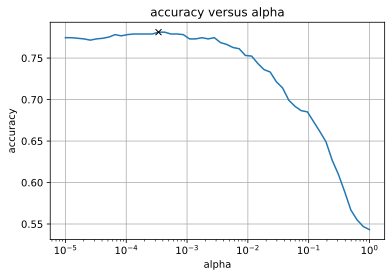

In [17]:
### INSERT YOUR CODE HERE

alphas = logspace(-5,0,50)
accs   = []

# TF-IDF feature extraction
tf_trans = feature_extraction.text.TfidfTransformer(use_idf=True, norm='l1')
trainXtf = tf_trans.fit_transform(trainX)
testXtf = tf_trans.transform(testX)

for myalpha in alphas:
    # fit a multinomial model (with smoothing)
    mmodel_tf = naive_bayes.MultinomialNB(alpha=myalpha)
    mmodel_tf.fit(trainXtf, trainY)

    # prediction
    predYtf = mmodel_tf.predict(testXtf)
    # calculate accuracy
    acc = metrics.accuracy_score(testY, predYtf)

    accs.append(acc)

# get best accuracy
bestalphai = argmax(accs)
bestalpha = alphas[bestalphai]
bestacc   = accs[bestalphai]
print("best alpha=", bestalpha, "\nbest acc=", bestacc)

# make a plot
plt.figure()
plt.semilogx(alphas, accs)
plt.semilogx(bestalpha, bestacc, 'kx')
plt.xlabel('alpha'); plt.ylabel('accuracy')     
plt.grid(True)  
plt.title('accuracy versus alpha');

## 6. Effect of vocabulary size
The vocabulary size also affects the accuracy.  Make another plot of accuracy versus vocabulary size.  Which vocabulary size yields the best result?

In [18]:
### INSERT YOUR CODE HERE

best maxf= 23789.947368421053 
best acc= 0.7812269031781227


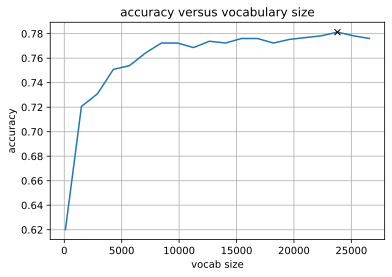

In [19]:
### INSERT YOUR CODE HERE

alpha       = 0.001
maxfeatures = linspace(100,26577,20)
accs   = []

for mf in maxfeatures:
    # create vocabulary, and extract counts
    cntvect = feature_extraction.text.CountVectorizer(stop_words='english', max_features=int(mf))
    trainX = cntvect.fit_transform(newsgroups_train.data)
    trainY = newsgroups_train.target
    testX  = cntvect.transform(newsgroups_test.data)
    testY  = newsgroups_test.target
    
    # TF-IDF feature extraction
    tf_trans = feature_extraction.text.TfidfTransformer(use_idf=True, norm='l1')
    trainXtf = tf_trans.fit_transform(trainX)
    testXtf = tf_trans.transform(testX)

    # fit a multinomial model (with smoothing)
    mmodel_tf = naive_bayes.MultinomialNB(alpha=alpha)
    mmodel_tf.fit(trainXtf, trainY)

    # prediction
    predYtf = mmodel_tf.predict(testXtf)
    # calculate accuracy
    acc = mean(predYtf==testY)
    
    accs.append(acc)

# get best accuracy
bestmfi = argmax(accs)
bestmf  = maxfeatures[bestmfi]
bestacc = accs[bestmfi]
print("best maxf=", bestmf, "\nbest acc=", bestacc)

# make a plot
plt.figure
plt.plot(maxfeatures, accs)
plt.plot(bestmf, bestacc, 'kx')
plt.xlabel('vocab size'); plt.ylabel('accuracy')     
plt.grid(True)  
plt.title('accuracy versus vocabulary size');